# Notebook for document detection in the image

In [1]:
#importing all the libraries
#pyimagesearch library is for four point perspective transform
from pyimagesearch import transform
from pyimagesearch import imutils
from scipy.spatial import distance as dist
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import cv2
import time
import argparse
import os
#opencv contrib module
from cv2.ximgproc import createStructuredEdgeDetection
from cv2.ximgproc import createFastLineDetector

In [2]:
%matplotlib inline

In [3]:
#for structured edge detection we will require a model file given by opencv
model_file = "model.yml.gz"
struct_edges = createStructuredEdgeDetection(model_file)
#for fast line detection 
lsd = createFastLineDetector()

In [8]:
#defining a class  for our dcoument scanner
class DocScanner():
    def __init__(self,MIN_QUAD_AREA_RATIO=0.25,MAX_QUAD_ANGLE_RANGE=30):
        '''
        MIN_QUAD_AREA_RATIO: All quadrilateral of area ratio less than this will be discarded
        MAX_QUAD_ANGLE_RANGE: A quadrilateral will be rejected if angle range is more than this'''
        self.prev_quad = []
        self.MIN_QUAD_AREA_RATIO = MIN_QUAD_AREA_RATIO
        self.MAX_QUAD_ANGLE_RANGE = MAX_QUAD_ANGLE_RANGE
        figure = plt.subplots(2,2,figsize=(15,15))
    def filter_corners(self, corners, min_dist=100):
        """Filters corners that are within min_dist of others"""
        def predicate(representatives, corner):
            return all(dist.euclidean(representative, corner) >= min_dist
                       for representative in representatives)

        filtered_corners = []
        for c in corners:
            if predicate(filtered_corners, c):
                filtered_corners.append(c)
        return filtered_corners
    def angle_between_vectors_degrees(self, u, v):
        """Returns the angle between two vectors in degrees"""
        return np.degrees(
            math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))  
    def get_angle(self, p1, p2, p3):
        """
        Returns the angle between the line segment from p2 to p1 
        and the line segment from p2 to p3 in degrees
        """
        a = np.radians(np.array(p1))
        b = np.radians(np.array(p2))
        c = np.radians(np.array(p3))

        avec = a - b
        cvec = c - b

        return self.angle_between_vectors_degrees(avec, cvec)
    def angle_range(self, quad):
        """
        Returns the range between max and min interior angles of quadrilateral.
        The input quadrilateral must be a numpy array with vertices ordered clockwise
        starting with the top left vertex.
        """
        tl, tr, br, bl = quad
        ura = self.get_angle(tl[0], tr[0], br[0])
        ula = self.get_angle(bl[0], tl[0], tr[0])
        lra = self.get_angle(tr[0], br[0], bl[0])
        lla = self.get_angle(br[0], bl[0], tl[0])

        angles = [ura, ula, lra, lla]
        return np.ptp(angles)          
    def get_corners(self, img):
        """
        Returns a list of corners ((x, y) tuples) found in the input image.
        """
        #finding the lines in the edged image
        lines = lsd.detect(img)
        draw_img = lsd.drawSegments(img,lines)
        
        corners = []
        if lines is not None:
            # separate out the horizontal and vertical lines, and draw them back onto separate canvases
            lines = lines.squeeze().astype(np.int32).tolist()
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for line in lines:
                x1, y1, x2, y2 = line
                if abs(x2 - x1) > abs(y2 - y1):
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
                    cv2.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, img.shape[1] - 1), y2), 255, 2)
                else:
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
                    cv2.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, img.shape[0] - 1)), 255, 2)

            lines = []

            # find the horizontal lines (connected-components -> bounding boxes -> final lines)
            contours = cv2.findContours(horizontal_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = contours[1]
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_x = np.amin(contour[:, 0], axis=0) + 2
                max_x = np.amax(contour[:, 0], axis=0) - 2
                left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
                right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
                lines.append((min_x, left_y, max_x, right_y))
                cv2.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
                corners.append((min_x, left_y))
                corners.append((max_x, right_y))

            # find the vertical lines (connected-components -> bounding boxes -> final lines)
            contours = cv2.findContours(vertical_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = contours[1]
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_y = np.amin(contour[:, 1], axis=0) + 2
                max_y = np.amax(contour[:, 1], axis=0) - 2
                top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
                bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
                lines.append((top_x, min_y, bottom_x, max_y))
                cv2.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
                corners.append((top_x, min_y))
                corners.append((bottom_x, max_y))

            # find the corners
            corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)
            corners += zip(corners_x, corners_y)

        # remove corners in close proximity
        corners = self.filter_corners(corners)
        return corners
    def is_valid_contour(self, cnt, IM_WIDTH, IM_HEIGHT):
        """Returns True if the contour satisfies all requirements set at instantitation"""

        return (len(cnt) == 4 and cv2.contourArea(cnt) > IM_WIDTH * IM_HEIGHT * self.MIN_QUAD_AREA_RATIO 
            and self.angle_range(cnt) < self.MAX_QUAD_ANGLE_RANGE)
    def get_contour(self, rescaled_image):
        """
        return the document points
        """
        # these constants are carefully chosen
        IM_HEIGHT, IM_WIDTH, _ = rescaled_image.shape
        #enhancing the contrast of the image using CLAHE method of opencv 
        clahe = cv2.createCLAHE(clipLimit=2.,tileGridSize=(8,8))
        lab  = cv2.cvtColor(rescaled_image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(lab)
        l2 = clahe.apply(l)
        lab = cv2.merge((l2,a,b))
        img = cv2.cvtColor(lab,cv2.COLOR_LAB2BGR)
        rescaled_image = np.float32(img)
        rescaled_image = rescaled_image/255
        #finding the edge map of the image using structured forest for line detection algorithm
        edged = struct_edges.detectEdges(rescaled_image)
        self.current_edges = edged
        edged = np.uint8(edged*255)
        #cv2.imshow('edged',edged)
        plt.subplot(2,2,2)
        plt.imshow(edged)
        test_corners = self.get_corners(edged)
        approx_contours = []

        if len(test_corners) >= 4:
            quads = []
            for quad in itertools.combinations(test_corners, 4):
                points = np.array(quad)
                points = transform.order_points(points)
                points = np.array([[p] for p in points], dtype = "int32")
                quads.append(points)

            # get top five quadrilaterals by area
            quads = sorted(quads, key=cv2.contourArea, reverse=True)[:10]
            # sort candidate quadrilaterals by their angle range, which helps remove outliers
            #quads = sorted(quads,key=self.probability,reverse=True)[:5]
            quads = sorted(quads, key=self.angle_range)

            approx = quads[0]
            if self.is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)

        # also attempt to find contours directly from the edged image, which occasionally 
        # produces better results
        (_, cnts, hierarchy) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if(len(self.prev_quad )==1):
            cnts.append(self.prev_quad)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

        # loop over the contours
        for c in cnts:
            # approximate the contour
            approx = cv2.approxPolyDP(c, 80, True)
            if self.is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)
                
        # If we did not find any valid contours, just use the whole image
        if not approx_contours:
            TOP_RIGHT = (IM_WIDTH, 0)
            BOTTOM_RIGHT = (IM_WIDTH, IM_HEIGHT)
            BOTTOM_LEFT = (0, IM_HEIGHT)
            TOP_LEFT = (0, 0)
            screenCnt = np.array([[TOP_RIGHT], [BOTTOM_RIGHT], [BOTTOM_LEFT], [TOP_LEFT]])
        else:
            screenCnt = max(approx_contours, key=cv2.contourArea)
        
        show_image = cv2.drawContours(rescaled_image, [screenCnt], -1,(20, 20, 255), 2,cv2.FILLED)
        plt.subplot(2,2,3)
        plt.imshow(show_image)
        self.prev_quad = screenCnt
        return screenCnt.reshape(4, 2)
    def scan(self, image):#image_path):

        RESCALED_HEIGHT = 300.0
        OUTPUT_DIR = 'output'
        assert(image is not None)
        plt.subplot(2,2,1)
        plt.imshow(image)
        ratio = image.shape[0] / RESCALED_HEIGHT
        orig = image.copy()
        rescaled_image = imutils.resize(image, height = int(RESCALED_HEIGHT))

        # get the contour of the document
        screenCnt = self.get_contour(rescaled_image)
        # apply the perspective transformation
        warped = transform.four_point_transform(orig, screenCnt * ratio)
        plt.subplot(2,2,4)
        plt.imshow(warped)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


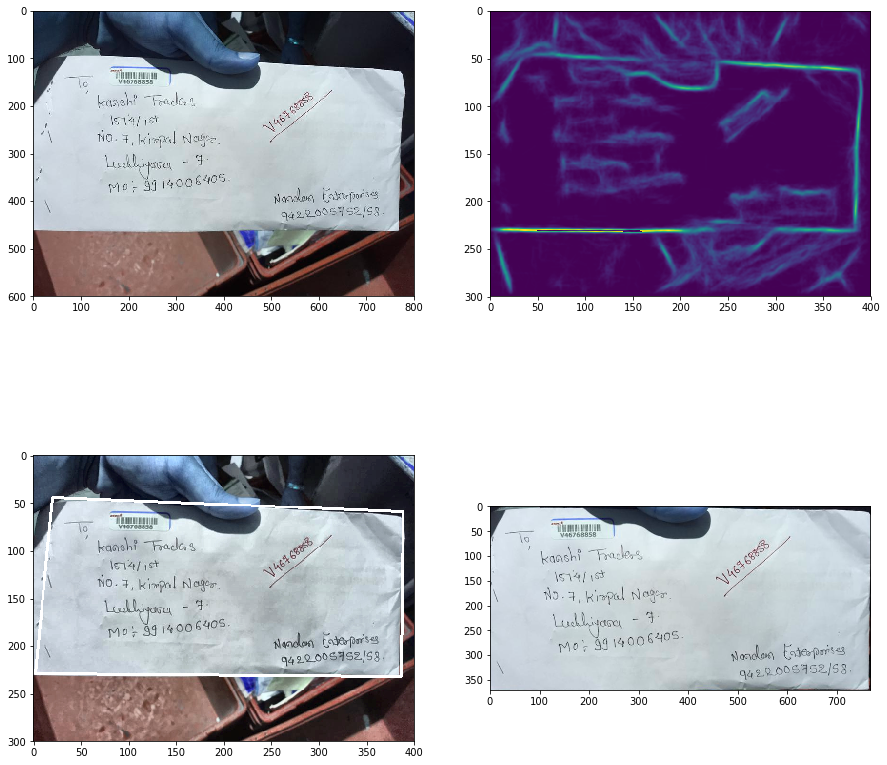

In [9]:
#running the algorithm
image_path =  "/home/shipsy/Downloads/OpenCV-Document-Scanner-master/resized_image/shipsy_dataset_handwritten_labels_242.jpg"
scanner = DocScanner()
image = cv2.imread(image_path)
scanner.scan(image)